### Using FDA_Drug and ZINC files to construct positive and negative samples for the dataset
Set random seeds as 41, 42, 43, 44, 45, 46, 47, 48, 49, 50 to complete 10 random splits

In [1]:
import pandas as pd
from sklearn.utils import shuffle

RANDOM_SEED = 50

fda_df = pd.read_csv('processed_results_FDA_Drug.csv')
fda_df['y'] = 1

zinc_df = pd.read_csv('processed_results_ZINC.csv')
chembl_df = pd.read_csv('processed_results_ChEMBL.csv')
gdb17_df = pd.read_csv('processed_results_GDB17.csv')

zinc_sample = shuffle(zinc_df, random_state=RANDOM_SEED).head(1000)
chembl_sample = shuffle(chembl_df, random_state=RANDOM_SEED).head(1000)
gdb17_sample = shuffle(gdb17_df, random_state=RANDOM_SEED).head(1000)

zinc_sample['y'] = 0
chembl_sample['y'] = 0
gdb17_sample['y'] = 0

combined_df = pd.concat([fda_df, zinc_sample, chembl_sample, gdb17_sample], ignore_index=True)

combined_df.to_csv('combined_predictions.csv', index=False)

print("Data has been successfully merged and saved as combined_predictions.csv")

Data has been successfully merged and saved as combined_predictions.csv


### First, we need to remove conventional physicochemical properties and only perform feature selection on ADMETlab3.0 features.
### A total of 16 conventional properties are removed: MW,Vol,Dense,nHA,nHD,TPSA,nRot,nRing,MaxRing,nHet,fChar,nRig,Flex,nStereo,mp,bp
### Also removed are 22 features that are either non-ADMET properties (such as environmental and fluorescence features) or have non-numerical prediction results, including: gasa, Reactive, Synth, Acute_Aquatic_Toxicity, NonBiodegradable, LD50_oral, Genotoxic_Carcinogenicity_Mutagenicity, Fluc, Blue_fluorescence, Green_fluorescence, Aggregators, Other_assay_interference, Alarm_NMR, Chelating, BMS, SureChEMBL, Skin_Sensitization, PAINS, NonGenotoxic_Carcinogenicity, FAF-Drugs4 Rule, Promiscuous
#### Features removed due to too many missing values: LM-mouse,LM-rat,cl-int

In [2]:
# Read combined_predictions.csv
combined_df = pd.read_csv('combined_predictions.csv')

# Columns not counted as endpoints
excluded_columns = ['SMILES', 'Source', 'y', 'smiles_standardized']

# Calculate number of endpoints before filtering
initial_endpoints = len(combined_df.columns) - len(excluded_columns)
print(f"Number of endpoints before filtering: {initial_endpoints}")

# Remove specified columns and save as new CSV file
columns_to_drop = [
    'MW', 'Vol', 'Dense', 'nHA', 'nHD', 'TPSA', 'nRot', 'nRing','mp','bp',
    'MaxRing', 'nHet', 'fChar', 'nRig', 'Flex', 'nStereo',
    'Reactive', 'Synth', 'Acute_Aquatic_Toxicity', 'NonBiodegradable',
    'LD50_oral', 'Genotoxic_Carcinogenicity_Mutagenicity',
    'Fluc', 'Blue_fluorescence', 'Green_fluorescence', 'Aggregators',
    'Other_assay_interference', 'Alarm_NMR', 'Chelating', 'BMS','SureChEMBL', 'Skin_Sensitization', 'PAINS',
    'NonGenotoxic_Carcinogenicity', 'FAF-Drugs4 Rule','LM-mouse','LM-rat','gasa','cl-int','Promiscuous'
]

filtered_df = combined_df.drop(columns=columns_to_drop)

# Calculate number of endpoints after filtering
final_endpoints = len(filtered_df.columns) - len(excluded_columns)
print(f"Number of endpoints after filtering: {final_endpoints}")

filtered_df.to_csv('filtered_predictions.csv', index=False)

print("Specified columns removed and saved as filtered_predictions.csv")



Number of endpoints before filtering: 123
Number of endpoints after filtering: 83
Specified columns removed and saved as filtered_predictions.csv


In [3]:
import numpy as np
df_filtered = pd.read_csv('filtered_predictions.csv')

missing_values = df_filtered.isnull().sum()
missing_columns = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Columns with missing values in filtered_predictions.csv:")
    print(missing_columns)
else:
    print("No missing values in filtered_predictions.csv")

non_numeric_columns = df_filtered.select_dtypes(exclude=[np.number]).columns

if not non_numeric_columns.empty:
    print("Non-numeric columns in filtered_predictions.csv:")
    print(non_numeric_columns)
else:
    print("No non-numeric columns in filtered_predictions.csv")


No missing values in filtered_predictions.csv
Non-numeric columns in filtered_predictions.csv:
Index(['smiles', 'smiles_standardized', 'Source'], dtype='object')


### After selecting the features for feature selection, we first fill the data outliers with mean values. Why use mean filling? Because we have 97 endpoints, assuming each endpoint has 0.1% outliers, meaning 99.5% can pass. After deletion, the remaining data would become 0.995 to the 100th power (0.6057), losing too much data, which we consider inappropriate. Therefore, we use mean filling for processing.
#### We perform data normalization
#### Perform min-max normalization on all features simultaneously to scale them between 0-1 for subsequent feature screening

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('filtered_predictions.csv')

columns_to_keep = ['smiles', 'Source', 'y', 'smiles_standardized']

columns_to_normalize = [col for col in df.columns if col not in columns_to_keep]

def impute_outliers_with_mean(df, columns):
    categorical_columns = [col for col in columns if set(df[col].unique()).issubset({0, 1, 0.0, 1.0})]
    numerical_columns = [col for col in columns if col not in categorical_columns]
    
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mean_value = df[col].mean()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean_value, df[col])
    return df

df_cleaned = impute_outliers_with_mean(df, columns_to_normalize)

scaler = MinMaxScaler()

df_cleaned[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])

final_columns = columns_to_keep + columns_to_normalize
df_final = df_cleaned[final_columns]

df_final.to_csv('preprocessed_predictions.csv', index=False)

print("Data has been preprocessed and saved as preprocessed_predictions.csv")

Data has been preprocessed and saved as preprocessed_predictions.csv


### Feature Selection Using Random Forest Method

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from scipy.stats import chi2_contingency

output_dir = f'RandomForestClassifier_{RANDOM_SEED}'
os.makedirs(output_dir, exist_ok=True)

data = pd.read_csv('preprocessed_predictions.csv')

X = data.drop(['y', 'smiles', 'Source','smiles_standardized'], axis=1)
y = data['y']

X = X.apply(pd.to_numeric, errors='coerce')

rf_fold_results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_features_list = []
top_n = 30

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold} started...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
    rf_importances = rf_importances.sort_values(ascending=False)
    
    rf_selected = rf_importances.index[:top_n].tolist()
    rf_features_list.extend(rf_selected)
    
    rf_fold_results.append({
        'fold': fold,
        'feature_importances': rf_importances
    })
    
    print(f"Fold {fold} completed.")

rf_features_counts = pd.Series(rf_features_list).value_counts()
print(f"Random forest feature occurrence counts in five-fold cross-validation:\n{rf_features_counts}")

plt.figure(figsize=(10, 8))
sns.barplot(x=rf_features_counts.values, y=rf_features_counts.index)
plt.title('Random Forest Features Selection Frequency')
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'RandomForestFeaturesSelectionFrequency.png'))
plt.close()

rf_final_selected_features = rf_features_counts.index[:top_n].tolist()
print(f"Final top {top_n} features selected by random forest:\n{rf_final_selected_features}")

for result in rf_fold_results:
    fold = result['fold']
    importances = result['feature_importances']
    importances_df = importances.reset_index()
    importances_df.columns = ['Feature', 'Importance']
    importances_df.to_csv(os.path.join(output_dir, f'rf_fold_{fold}_importances.csv'), index=False)
    print(f"Fold {fold} feature importance saved to {os.path.join(output_dir, f'rf_fold_{fold}_importances.csv')}")

Fold 1 started...
Fold 1 completed.
Fold 2 started...
Fold 2 completed.
Fold 3 started...
Fold 3 completed.
Fold 4 started...
Fold 4 completed.
Fold 5 started...
Fold 5 completed.
Random forest feature occurrence counts in five-fold cross-validation:
Natural Product-likeness    5
cl-plasma                   5
Carcinogenicity             5
CYP2C9-sub                  5
Hematotoxicity              5
Fsp3                        5
OATP1B3                     5
Neurotoxicity-DI            5
DILI                        5
caco2                       5
HEK293                      5
BBB                         5
CYP3A4-inh                  5
hERG-10um                   5
ROA                         5
EI                          5
f30                         5
CYP3A4-sub                  5
MCE-18                      5
GoldenTriangle              5
CYP2D6-sub                  5
CYP2C19-inh                 5
Ames                        5
CYP2B6-inh                  5
FDAMDD                      5


Starting Mutual Information Feature Selection...
Starting Mutual Information Feature Selection for fold 1...
Mutual Information Feature Selection for fold 1 completed, results saved to Mutual_Information_50\mi_fold_1_importances.csv
Starting Mutual Information Feature Selection for fold 2...
Mutual Information Feature Selection for fold 2 completed, results saved to Mutual_Information_50\mi_fold_2_importances.csv
Starting Mutual Information Feature Selection for fold 3...
Mutual Information Feature Selection for fold 3 completed, results saved to Mutual_Information_50\mi_fold_3_importances.csv
Starting Mutual Information Feature Selection for fold 4...
Mutual Information Feature Selection for fold 4 completed, results saved to Mutual_Information_50\mi_fold_4_importances.csv
Starting Mutual Information Feature Selection for fold 5...
Mutual Information Feature Selection for fold 5 completed, results saved to Mutual_Information_50\mi_fold_5_importances.csv
Mutual Information feature sel

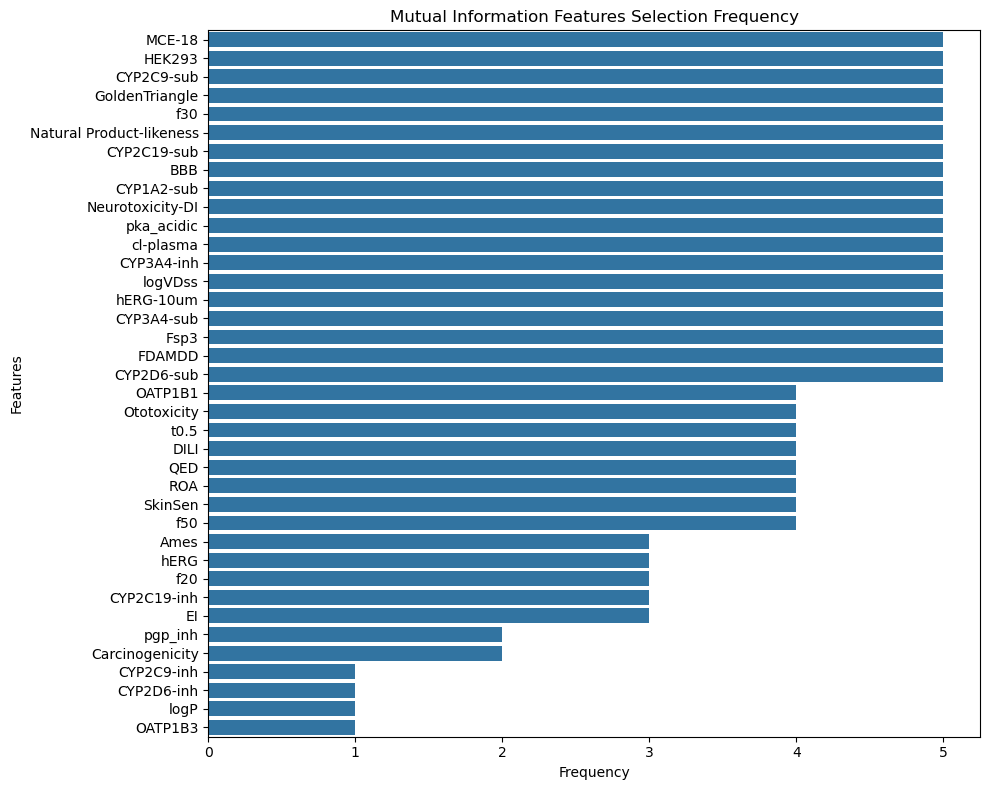

Mutual Information final top 30 selected features:
['MCE-18', 'HEK293', 'CYP2C9-sub', 'GoldenTriangle', 'f30', 'Natural Product-likeness', 'CYP2C19-sub', 'BBB', 'CYP1A2-sub', 'Neurotoxicity-DI', 'pka_acidic', 'cl-plasma', 'CYP3A4-inh', 'logVDss', 'hERG-10um', 'CYP3A4-sub', 'Fsp3', 'FDAMDD', 'CYP2D6-sub', 'OATP1B1', 'Ototoxicity', 't0.5', 'DILI', 'QED', 'ROA', 'SkinSen', 'f50', 'Ames', 'hERG', 'f20']

Comprehensively selected features (intersection):
['CYP3A4-inh', 'hERG-10um', 'Neurotoxicity-DI', 'CYP1A2-sub', 'GoldenTriangle', 'DILI', 'CYP2C9-sub', 'logVDss', 'OATP1B1', 'Fsp3', 'f50', 'CYP2D6-sub', 'BBB', 'f30', 'Ames', 'Natural Product-likeness', 'HEK293', 'CYP3A4-sub', 'MCE-18', 'FDAMDD', 'ROA', 'cl-plasma']


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

print("\nStarting Mutual Information Feature Selection...")

mi_output_dir = f'Mutual_Information_{RANDOM_SEED}'
os.makedirs(mi_output_dir, exist_ok=True)

mi_features_list = []

top_n = 30

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Starting Mutual Information Feature Selection for fold {fold}...")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    mi = mutual_info_classif(X_train, y_train, random_state=42)
    mi_series = pd.Series(mi, index=X.columns)
    mi_series = mi_series.sort_values(ascending=False)
    
    mi_selected = mi_series.index[:top_n].tolist()
    mi_features_list.extend(mi_selected)
    
    mi_fold_df = mi_series.reset_index()
    mi_fold_df.columns = ['Feature', 'MutualInformation']
    mi_fold_df.to_csv(os.path.join(mi_output_dir, f'mi_fold_{fold}_importances.csv'), index=False)
    
    print(f"Mutual Information Feature Selection for fold {fold} completed, results saved to {os.path.join(mi_output_dir, f'mi_fold_{fold}_importances.csv')}")

mi_features_counts = pd.Series(mi_features_list).value_counts()
print(f"Mutual Information feature selection occurrence counts in five-fold cross-validation:\n{mi_features_counts}")

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_features_counts.values, y=mi_features_counts.index)
plt.title('Mutual Information Features Selection Frequency')
plt.xlabel('Frequency')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig(os.path.join(mi_output_dir, 'MutualInfoFeaturesSelectionFrequency.png'))
plt.show()

mi_final_selected_features = mi_features_counts.index[:top_n].tolist()
print(f"Mutual Information final top {top_n} selected features:\n{mi_final_selected_features}")

selected_features = list(set(rf_final_selected_features) & set(mi_final_selected_features))
print(f"\nComprehensively selected features (intersection):\n{selected_features}")